# 内容理解

## 自然场景字体检测

In [2]:
import cv2
import time,math
import numpy as np
from random import randint
#pip install imutils -i https://mirrors.aliyun.com/pypi/simple/
from imutils.object_detection import non_max_suppression
image = cv2.imread("../img/opencv_text_detection_result01.jpg")

net = cv2.dnn.readNet('../model/frozen_east_text_detection.pb')

In [3]:
# load the input image and grab the image dimensions
orig = image.copy()
(H, W) = image.shape[:2]

# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (320, 320)
rW = W / float(newW)
rH = H / float(newH)

# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

In [4]:
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
                             (123.68, 116.78, 103.94), swapRB=True, crop=False)


In [5]:
outputLayers = []
outputLayers.append("feature_fusion/Conv_7/Sigmoid")
outputLayers.append("feature_fusion/concat_3")

net.setInput(blob)
output = net.forward(outputLayers)
#print(output)
scores = output[0]
geometry = output[1]

confThreshold=0.5



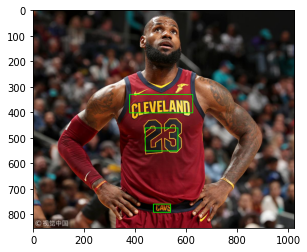

In [6]:
from matplotlib import pyplot as plt
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

# loop over the number of rows
for y in range(0, numRows):
    # extract the scores (probabilities), followed by the geometrical
    # data used to derive potential bounding box coordinates that
    # surround text
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]

    # loop over the number of columns
    for x in range(0, numCols):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < confThreshold:
            continue

        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)

        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)

        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]

        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)

        # add the bounding box coordinates and probability score to
        # our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    # draw the bounding box on the image
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

# show the output image
plt.imshow(cv2.cvtColor(orig,cv2.COLOR_BGR2RGB))
plt.show()

In [7]:
cv2.imwrite('test.png',orig)

True

## 多人姿势评估

Time Taken in forward pass = 2.1746602058410645


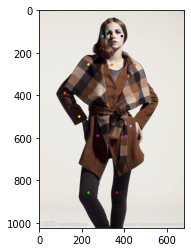

No Connection : k = 8
No Connection : k = 11


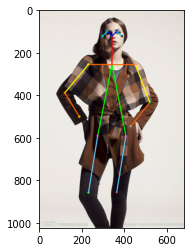

In [25]:
import cv2
import time
import numpy as np
from random import randint

image1 = cv2.imread("../img/model.jpg")

protoFile = "../model/pose_deploy_linevec.prototxt"
weightsFile = "../model/pose_iter_440000.caffemodel"

# protoFile = "pose/coco/pose_deploy_linevec.prototxt"
# weightsFile = "pose/coco/pose_iter_440000.caffemodel"
nPoints = 18
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44],
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30],
          [47,48], [49,50], [53,54], [51,52], [55,56],
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]


def getKeypoints(probMap, threshold=0.1):

    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []

    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints


# Find valid connections between the different joints of a all persons present
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid

        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ])
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)

                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    return valid_pairs, invalid_pairs



# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
def getPersonwiseKeypoints(valid_pairs, invalid_pairs):
    # the last number in each row is the overall score
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])):
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints


frameWidth = image1.shape[1]
frameHeight = image1.shape[0]

t = time.time()
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Fix the input Height and get the width according to the Aspect Ratio
inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)

inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
print("Time Taken in forward pass = {}".format(time.time() - t))

detected_keypoints = []
keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.1

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
    keypoints = getKeypoints(probMap, threshold)
    #print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)


frameClone = image1.copy()
for i in range(nPoints):
    for j in range(len(detected_keypoints[i])):
        cv2.circle(frameClone, detected_keypoints[i][j][0:2], 5, colors[i], -1, cv2.LINE_AA)

#Keypoints
plt.imshow(cv2.cvtColor(frameClone,cv2.COLOR_BGR2RGB))
plt.show() 

valid_pairs, invalid_pairs = getValidPairs(output)
personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

for i in range(17):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)

        
plt.imshow(cv2.cvtColor(frameClone,cv2.COLOR_BGR2RGB))
plt.show() 


## 实例分割

In [26]:
p='''airplane

person
'''

p.rstrip('\n').split('\n')

['airplane', '', 'person']

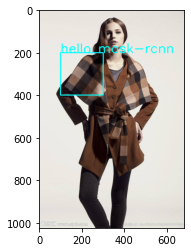

In [28]:
image = cv2.imread('../img/model.jpg') 
cv2.rectangle(image, (100, 200), (300,399), (255,255,0), 3) 

cv2.putText(image, "hello mask-rcnn", (100,200), cv2.FONT_HERSHEY_SIMPLEX,2, (255,255,0),4)

plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show() 


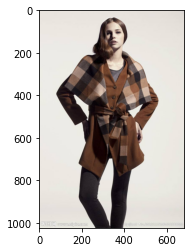

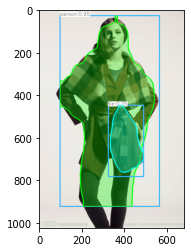

In [9]:
import cv2
import numpy as np
import os.path
import sys
import random
from matplotlib import pyplot as plt


#test
ps=[]

# Initialize the parameters
confThreshold = 0.5  # Confidence threshold
maskThreshold = 0.3  # Mask threshold

#   Draw the predicted bounding box, colorize and show the mask on the image
def drawBox(frame, classId, conf, left, top, right, bottom, classMask):
    # Draw a bounding box.
    
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3) 
    # Print a label of class.
    label = '%.2f' % conf
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)
    
#     print(label)
#     if label.count("person")>0:
#         ps.append(frame[top:bottom+1, left:right+1])
        
    # Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)
   
    # Resize the mask, threshold, color and apply it on the image
    classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
    mask = (classMask > maskThreshold)
    roi = frame[top:bottom+1, left:right+1][mask]

    # color = colors[classId%len(colors)]
    # Comment the above line and uncomment the two lines below to generate different instance colors
    colorIndex = random.randint(0, len(colors)-1)
    color = colors[colorIndex]
    
    frame[top:bottom+1, left:right+1][mask] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.7 * roi).astype(np.uint8)

    # Draw the contours on the image
    mask = mask.astype(np.uint8)
    #print('mask:',mask)
    #print(len(cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)))
    contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(frame[top:bottom+1, left:right+1], contours, -1, color, 3, cv2.LINE_8, hierarchy, 100)

# For each frame, extract the bounding box and mask for each detected object
def postprocess(boxes, masks):
    # Output size of masks is NxCxHxW where
    # N - number of detected boxes
    # C - number of classes (excluding background)
    # HxW - segmentation shape
    numClasses = masks.shape[1]
    numDetections = boxes.shape[2]

    frameH = frame.shape[0]
    frameW = frame.shape[1]

    for i in range(numDetections):
        box = boxes[0, 0, i]
        mask = masks[i]
        score = box[2]
        if score > confThreshold:
            classId = int(box[1])
            
            # Extract the bounding box
            left = int(frameW * box[3])
            top = int(frameH * box[4])
            right = int(frameW * box[5])
            bottom = int(frameH * box[6])
            
            left = max(0, min(left, frameW - 1))
            top = max(0, min(top, frameH - 1))
            right = max(0, min(right, frameW - 1))
            bottom = max(0, min(bottom, frameH - 1))
            
            # Extract the mask for the object
            classMask = mask[classId]
            
            # Draw bounding box, colorize and show the mask on the image
            drawBox(frame, classId, score, left, top, right, bottom, classMask)


# Load names of classes
classesFile = "../model/mask_rcnn_inception_v2_coco_2018_01_28/mscoco_labels.names";
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')


# Give the textGraph and weight files for the model
textGraph = "../model/mask_rcnn_inception_v2_coco_2018_01_28/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt";
modelWeights = "../model/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb";

# Load the network
model = cv2.dnn.readNetFromTensorflow(modelWeights, textGraph);
model.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
model.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Load the classes
colorsFile = "../model/mask_rcnn_inception_v2_coco_2018_01_28/colors.txt";
with open(colorsFile, 'rt') as f:
    colorsStr = f.read().rstrip('\n').split('\n')
    
colors = [] #[0,0,0]

for i in range(len(colorsStr)):
    rgb = colorsStr[i].split(' ')
    color = np.array([float(rgb[0]), float(rgb[1]), float(rgb[2])])
    colors.append(color)


frame = cv2.imread('../img/model.jpg')  
#print('frame:',frame)
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
plt.show() 


# Create a 4D blob from a frame.
blob = cv2.dnn.blobFromImage(frame, swapRB=True, crop=False)
#print('blob:',blob)

# Set the input to the network
model.setInput(blob)

# Run the forward pass to get output from the output layers
boxes, masks = model.forward(['detection_out_final', 'detection_masks'])
#print(boxes,masks)

# Extract the bounding box and mask for each of the detected objects
postprocess(boxes, masks)

# Put efficiency information.
t, _ = model.getPerfProfile()
label =abs(t * 1000.0 / cv2.getTickFrequency())
#print(label)
#cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
plt.show()   

## 人脸、性别、年龄

gender : female, conf = 0.631
age : (8-12), conf = 0.975


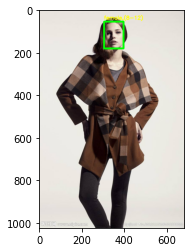

In [2]:
import cv2
import math
import time
from matplotlib import pyplot as plt


def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes


faceProto = "../model/face_detector/opencv_face_detector.pbtxt"
faceModel = "../model/face_detector/opencv_face_detector_uint8.pb"

ageProto = "../model/cnn_age_gender_models/age_deploy.prototxt"
ageModel = "../model/cnn_age_gender_models/age_net.caffemodel"

genderProto = "../model/cnn_age_gender_models/gender_deploy.prototxt"
genderModel = "../model/cnn_age_gender_models/gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
age_list = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
gender_list = ['male', 'female']

# 加载预训练模型
ageNet = cv2.dnn.readNet(ageModel, ageProto)
genderNet = cv2.dnn.readNet(genderModel, genderProto)
faceNet = cv2.dnn.readNet(faceModel, faceProto)

# Open a video file or an image file or a camera stream
#cap = cv.VideoCapture(0)
padding = 20

img = cv2.imread('../img/model.jpg')

img_face, bboxes = getFaceBox(faceNet, img)
if not bboxes:
    print("No face Detected, Checking next frame")


for bbox in bboxes:
    # print(bbox)
    face = img[max(0,bbox[1]-padding):min(bbox[3]+padding,img.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, img.shape[1]-1)]
    #print(face)
    blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
    genderNet.setInput(blob)
    genderPreds = genderNet.forward()
    #print(genderPreds)
    gender = gender_list[genderPreds[0].argmax()]
    # print("Gender Output : {}".format(genderPreds))
    print("gender : {}, conf = {:.3f}".format(gender, genderPreds[0].max()))

    ageNet.setInput(blob)
    agePreds = ageNet.forward()
    #print(agePreds)
    age = age_list[agePreds[0].argmax()]
    #print("Age Output : {}".format(agePreds))
    print("age : {}, conf = {:.3f}".format(age, agePreds[0].max()))

    label = "{},{}".format(gender, age)
    cv2.putText(img_face, label, (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)
    #cv.imshow("Age Gender Demo", img_face)
    plt.imshow(cv2.cvtColor(img_face,cv2.COLOR_BGR2RGB))
    plt.show()

# 边缘检测

## canny算子

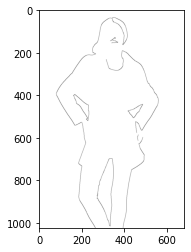

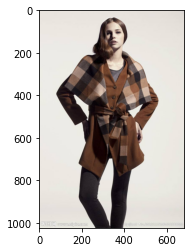

In [3]:
# opencv
import cv2 
import numpy as np
from matplotlib import pyplot as plt

#opencv读取图片，默认是BGR
#img=cv2.imread('img/img_94.png',cv2.IMREAD_COLOR)
#img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.imshow(img)
#plt.show()

lowThreshold = 200  #canny算法中的一个阈值参数
max_lowThreshold = 300  #canny算法中的另一个阈值参数
ratio = 3  
kernel_size = 3  #canny算法中的一个参数，这个默认选3就行

#加载测试图片
img = cv2.imread('../img/model.jpg')  

#把图片转成灰度图
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 

#像素3的高斯模糊，过滤掉小噪点
gray = cv2.GaussianBlur(gray,(3,3),0)  

#调用opencv自带的canny算法
gray = cv2.Canny(gray,lowThreshold,lowThreshold*ratio,apertureSize = kernel_size)

#黑白反转，使得背景为白色
gray = 255 -gray

#转成rgb，以便于matplotlib显示
gray=cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) 

#显示
plt.imshow(gray)
plt.show()

plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()



## HED 深度学习

In [4]:
#查看opencv的 版本
cv2.__version__

'4.2.0'

In [5]:
class CropLayer(object):
    def __init__(self, params, blobs):
        self.xstart = 0
        self.xend = 0
        self.ystart = 0
        self.yend = 0
 
    # Our layer receives two inputs. We need to crop the first input blob
    # to match a shape of the second one (keeping batch size and number of channels)
    def getMemoryShapes(self, inputs):
        inputShape, targetShape = inputs[0], inputs[1]
        batchSize, numChannels = inputShape[0], inputShape[1]
        height, width = targetShape[2], targetShape[3]
 
        #self.ystart = (inputShape[2] - targetShape[2]) / 2
        #self.xstart = (inputShape[3] - targetShape[3]) / 2
 
        self.ystart = int((inputShape[2] - targetShape[2]) / 2)
        self.xstart = int((inputShape[3] - targetShape[3]) / 2)
 
        self.yend = self.ystart + height
        self.xend = self.xstart + width
 
        return [[batchSize, numChannels, height, width]]
 
    def forward(self, inputs):
        return [inputs[0][:,:,self.ystart:self.yend,self.xstart:self.xend]]
#! [CropLayer]
 
#! [Register]
cv2.dnn_registerLayer('Crop', CropLayer)


In [7]:
# 加载模型
# hed_pretrained_bsds.caffemodel预训练模型下载http://vcl.ucsd.edu/hed/hed_pretrained_bsds.caffemodel
# deploy.prototxt 下载https://github.com/s9xie/hed/tree/master/examples/hed
net = cv2.dnn.readNet('../model/hed/deploy.prototxt', '../model/hed/hed_pretrained_bsds.caffemodel')

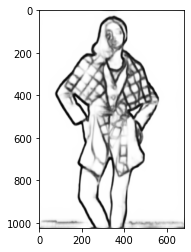

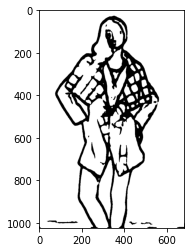

In [8]:
#Resize input image to a specific width and height 
width=400
height=400

img = cv2.imread('../img/model.jpg')  

inp = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(width,height),
                               mean=(104.00698793, 116.66876762, 122.67891434),
                               swapRB=False, crop=False)
net.setInput(inp)
 
out = net.forward()

out = out[0, 0]
out = cv2.resize(out, (img.shape[1], img.shape[0]))
out=cv2.cvtColor(out,cv2.COLOR_GRAY2RGB) 

out=1-out

plt.imshow(out)
plt.show()

#二值化
t=cv2.cvtColor(np.uint8(out*255),cv2.COLOR_RGB2GRAY)
thresh_map = cv2.threshold(t, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(cv2.cvtColor(thresh_map,cv2.COLOR_GRAY2RGB))
plt.show()

# 显著性 

In [3]:
#  查看模块是否存在
cv2.saliency

<module 'cv2.saliency'>

### 依赖于图像特征和统计信息来定位图像中显著性区域

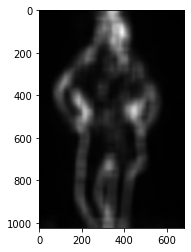

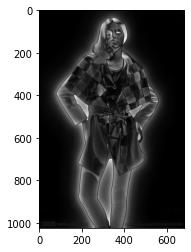

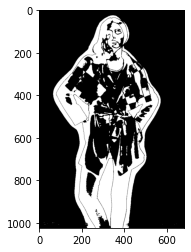

In [6]:
img = cv2.imread('../img/model.jpg')

#StaticSaliencySpectralResidual_create
#
saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
(success, saliency_map) = saliency.computeSaliency(img)
saliency_map = (saliency_map * 255).astype("uint8")

plt.imshow(cv2.cvtColor(saliency_map,cv2.COLOR_BGR2RGB))
plt.show()


# StaticSaliencyFineGrained_create
saliency = cv2.saliency.StaticSaliencyFineGrained_create()
(success, saliency_map) = saliency.computeSaliency(img)
saliency_map = (saliency_map * 255).astype("uint8")

plt.imshow(cv2.cvtColor(saliency_map,cv2.COLOR_BGR2RGB))
plt.show()

# 用于从灰度图像中获取二进制图像或用于消除噪声，即滤除太小或太小的像素
thresh_map = cv2.threshold(saliency_map, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

plt.imshow(cv2.cvtColor(thresh_map,cv2.COLOR_BGR2RGB))
plt.show()

# 固定阈值分割

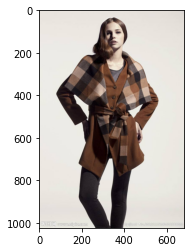

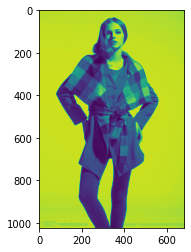

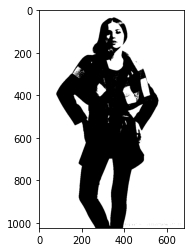

In [7]:
# 
img = cv2.imread('../img/model.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

plt.imshow(gray)
plt.show()

gray = cv2.threshold(gray,0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

plt.imshow(cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB))
plt.show()

# 自适应阈值分割

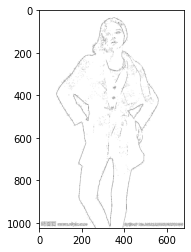

1708.5


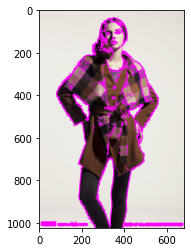

In [8]:
#读取文件
img = cv2.imread('../img/model.jpg')

#高斯滤波
#img=cv2.GaussianBlur(img,(3,3),0)

gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#自适应分割
dst = cv2.adaptiveThreshold(gray,210,cv2.BORDER_REPLICATE,cv2.THRESH_BINARY_INV,3,10)

#显示结果
plt.imshow(cv2.cvtColor(255-dst,cv2.COLOR_GRAY2RGB))
plt.show()

#提取轮廓
contours,heridency = cv2.findContours(dst,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
#标记轮廓
cv2.drawContours(img,contours,-1,(255,0,255),3)

#计算轮廓面积
area = 0
for i in contours:
    area += cv2.contourArea(i)
print(area)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()